# TimeSeries-Hub: Synthetic Time Series Generation

This is a demo demonstration of realistic time series pattern generation using the timeseries-hub datasets module. (library)

## Setup

In [1]:
# Adding the datasets module into the path (since the library is not installed)
# These lines won't be needed when the library will be fully developed and installed

import os 
import sys
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)

# Add parent directory to sys.path
sys.path.append('../..')

try:
    from datasets.generators import LinearTrendGenerator, SeasonalGenerator
except ImportError:
    logging.error("Module cannot be imported, no file found")
else:
    logging.info(
        f"Successfully imported LinearTrendGenerator and SeasonalGenerator from datasets.generators"
    )

# ================ This is another way to declare the project path to the notebook ====
# Add project root to Python path (since library not installed)
# current_dir = os.getcwd()  
# project_root = os.path.dirname(os.path.dirname(current_dir))  
# sys.path.insert(0, project_root)

INFO:numexpr.utils:NumExpr defaulting to 16 threads.
INFO:root:Successfully imported LinearTrendGenerator and SeasonalGenerator from datasets.generators


In [2]:
# Import the working libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

from datasets.generators import LinearTrendGenerator
from datasets.generators import SeasonalGenerator
from datasets.generators import WhiteNoiseGenerator
from datasets.generators import CompositeGenerator

# Configure plotting
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print('Environment Setup successful!!')

Environment Setup successful!!


## Example 1: Linear Trend with Seasonality

Generate a simple business-like time series combining growth trend with seasonal patterns.

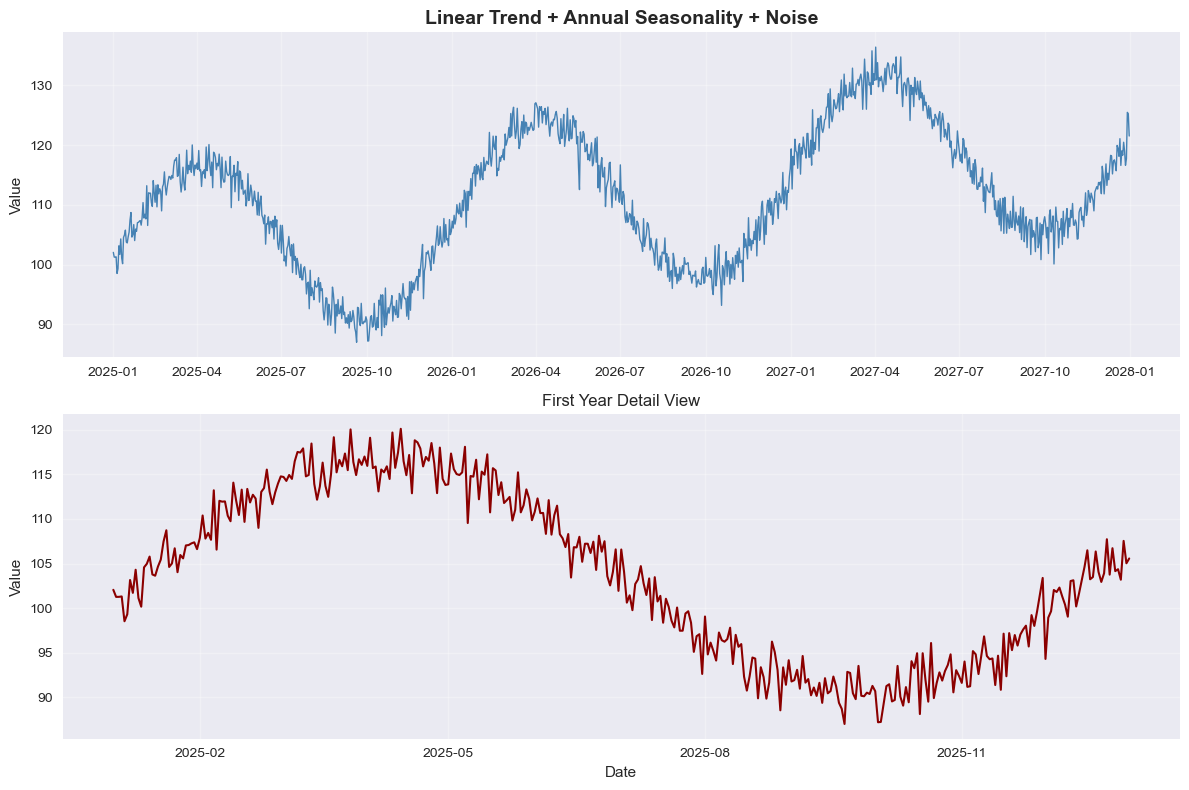

In [3]:
# Create individual components
trend_gen = LinearTrendGenerator(slope=0.02, intercept=100, noise_std=0)
seasonal_gen = SeasonalGenerator(period=365, amplitude=15, noise_std=0)
noise_gen = WhiteNoiseGenerator(mean=0, std=2.0)

# Combine components
composite_gen = CompositeGenerator(
    generators=[trend_gen, seasonal_gen, noise_gen],
    combination_method='additive'
)

# Generate 3 years of daily data
trend_seasonal = composite_gen.generate(n_points=1095, freq='D')

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Full time series
ax1.plot(trend_seasonal.index, trend_seasonal.values, color='steelblue', linewidth=1)
ax1.set_title('Linear Trend + Annual Seasonality + Noise', fontsize=14, fontweight='bold')
ax1.set_ylabel('Value')
ax1.grid(True, alpha=0.3)

# Zoom in on first year
first_year = trend_seasonal.iloc[:365]
ax2.plot(first_year.index, first_year.values, color='darkred', linewidth=1.5)
ax2.set_title('First Year Detail View', fontsize=12)
ax2.set_xlabel('Date')
ax2.set_ylabel('Value')
ax2.grid(True, alpha=0.3)

# Format dates
for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))

plt.tight_layout()
plt.show()

In [4]:
print(f"Generated {len(trend_seasonal)} data points")
print(f"Date range: {trend_seasonal.index[0].strftime('%Y-%m-%d')} to {trend_seasonal.index[-1].strftime('%Y-%m-%d')}")
print(f"Value range: {trend_seasonal.min():.1f} to {trend_seasonal.max():.1f}")

Generated 1095 data points
Date range: 2025-01-01 to 2027-12-31
Value range: 87.0 to 136.4


## Example 2: Realistic Economic Data

Generate GDP-like economic time series with business cycles and random shocks.

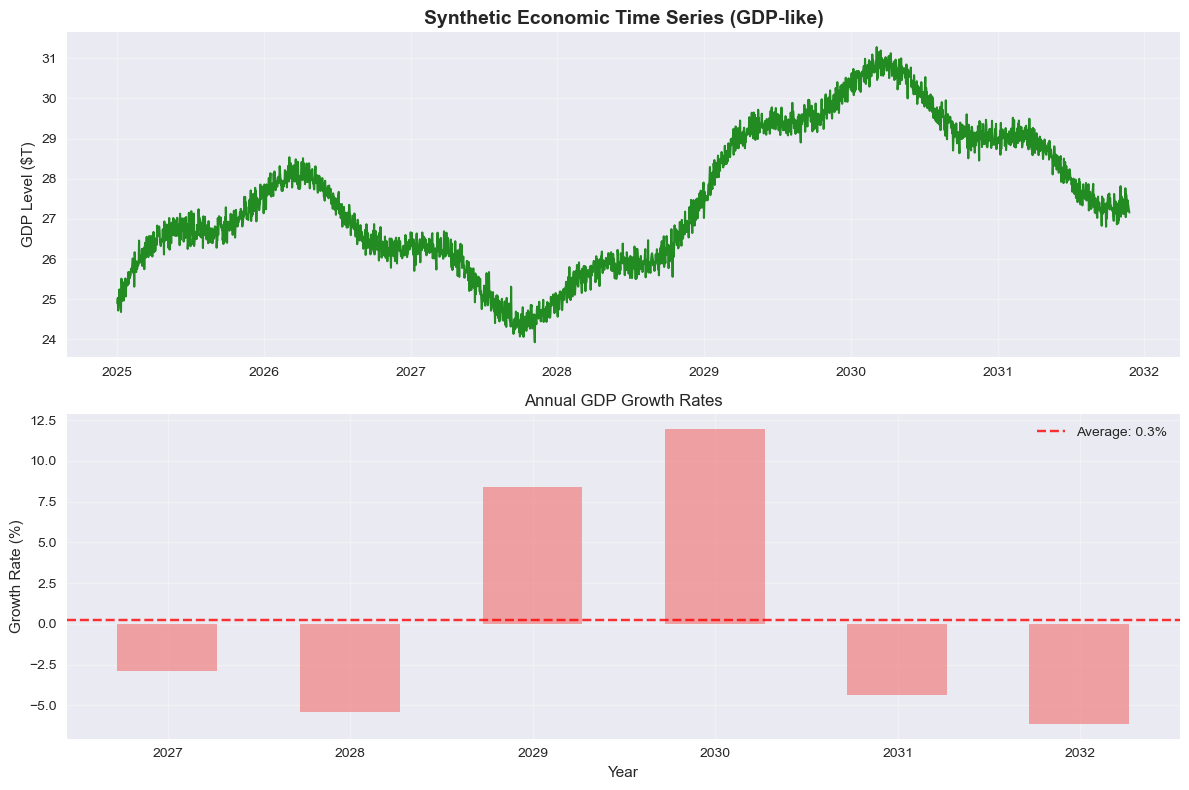

In [5]:
from datasets.generators.composite import EconomicSeriesGenerator

# Create economic series generator
economic_gen = EconomicSeriesGenerator(
    initial_level=25000,          # $25T starting GDP
    growth_rate=0.025,            # 2.5% annual growth
    business_cycle_period=1460,   # 4-year business cycles  
    business_cycle_amplitude=0.08, # 8% cycle amplitude
    seasonal_strength=0.02,       # Mild quarterly seasonality
    volatility=0.008,             # Low daily volatility
    shock_probability=0.003,      # Rare economic shocks
    shock_magnitude=0.05          # 5% shock magnitude
)

# Generate 10 years of economic data
economic_data = economic_gen.generate(n_points=2520, freq='D')  # ~10 years

# Calculate annual growth rates
annual_data = economic_data.resample('YE').last()
growth_rates = annual_data.pct_change().dropna() * 100

# Plot economic series
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# GDP level
ax1.plot(economic_data.index, economic_data.values/1000, color='forestgreen', linewidth=1.5)
ax1.set_title('Synthetic Economic Time Series (GDP-like)', fontsize=14, fontweight='bold')
ax1.set_ylabel('GDP Level ($T)')
ax1.grid(True, alpha=0.3)

# Annual growth rates
ax2.bar(growth_rates.index, growth_rates.values, color='lightcoral', alpha=0.7, width=200)
ax2.axhline(y=growth_rates.mean(), color='red', linestyle='--', alpha=0.8, 
           label=f'Average: {growth_rates.mean():.1f}%')
ax2.set_title('Annual GDP Growth Rates', fontsize=12)
ax2.set_xlabel('Year')
ax2.set_ylabel('Growth Rate (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
print(f"Economic series statistics:")
print(f"• Average level: ${economic_data.mean()/1000:.1f}T")
print(f"• Average annual growth: {growth_rates.mean():.1f}%")
print(f"• Growth volatility: {growth_rates.std():.1f}%")

Economic series statistics:
• Average level: $27.5T
• Average annual growth: 0.3%
• Growth volatility: 7.8%


## Example 3: Financial Market Simulation

Generate realistic stock prices with volatility clustering using GARCH effects.

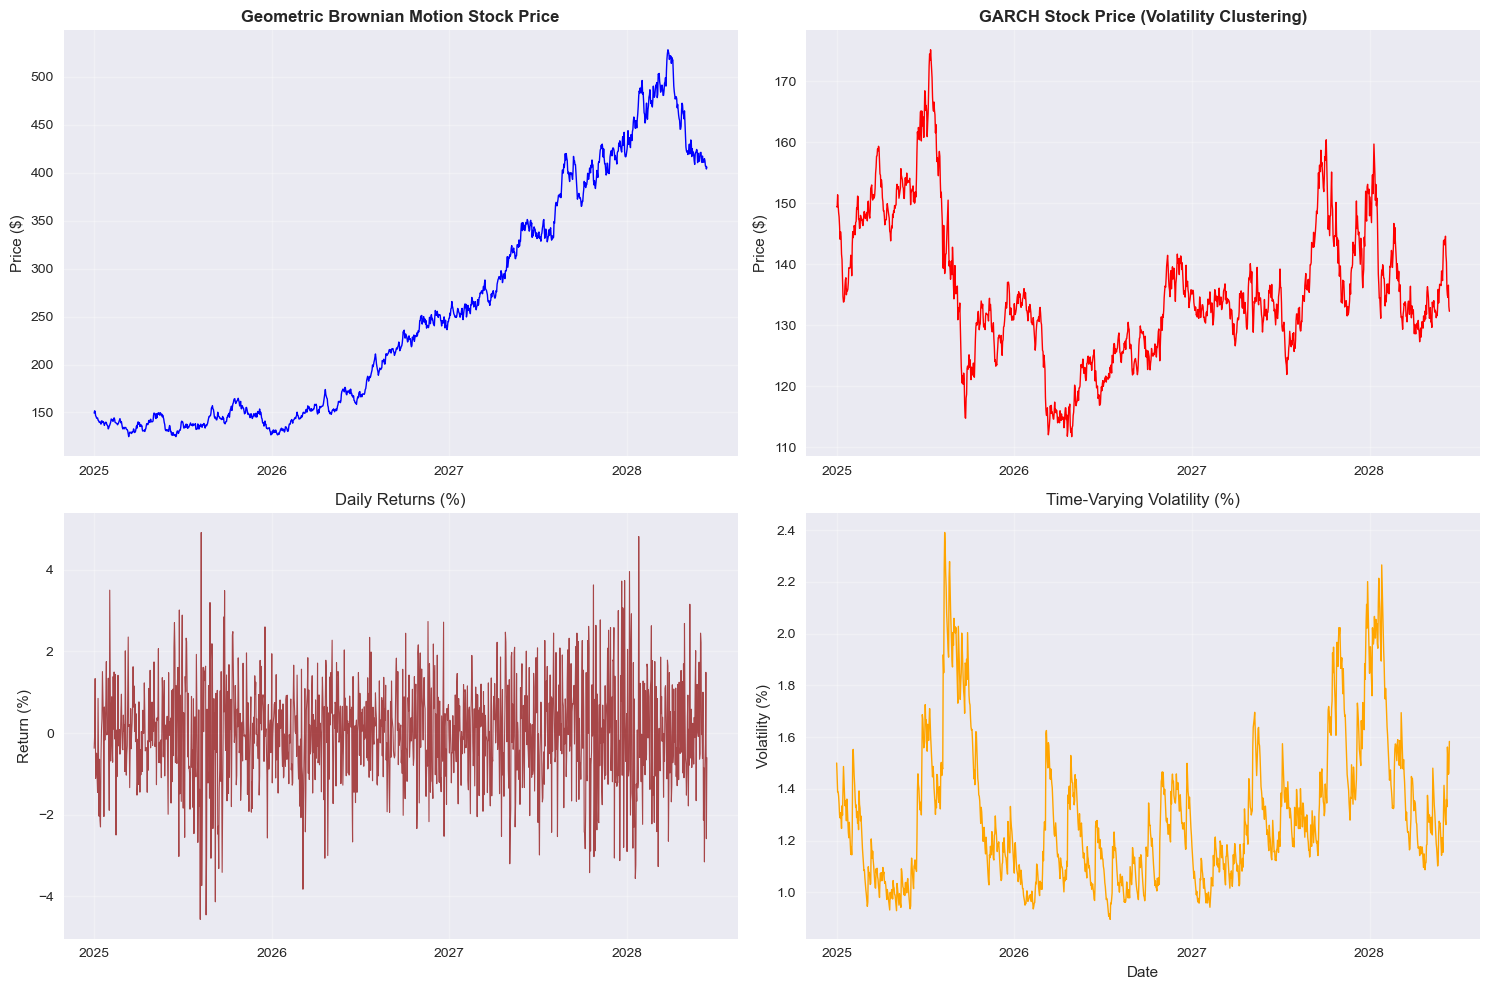

In [7]:
from datasets.generators.financial import GeometricBrownianMotionGenerator, GARCHGenerator

# Generate stock price using Geometric Brownian Motion
stock_gen = GeometricBrownianMotionGenerator(
    initial_price=150.0,
    drift=0.08,                   # 8% annual expected return
    volatility=0.25,              # 25% annual volatility
    time_step=1/252               # Daily time step
)

# Generate stock prices
stock_prices = stock_gen.generate(n_points=1260)  # 5 years of trading days

# Generate realistic returns with volatility clustering
garch_gen = GARCHGenerator(
    omega=0.000005,               # Low baseline variance
    alpha=0.08,                   # Moderate shock reaction
    beta=0.90,                    # High volatility persistence
    initial_volatility=0.015      # 1.5% daily volatility
)

# Generate returns and volatility
returns, volatility = garch_gen.generate(n_points=1260, return_volatility=True)

# Convert returns to prices starting from $150
garch_prices = pd.Series(150 * np.exp(returns.cumsum()), index=returns.index, name='garch_price')

# Plot comparison
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# GBM Stock prices
ax1.plot(stock_prices.index, stock_prices.values, color='blue', linewidth=1)
ax1.set_title('Geometric Brownian Motion Stock Price', fontsize=12, fontweight='bold')
ax1.set_ylabel('Price ($)')
ax1.grid(True, alpha=0.3)

# GARCH Stock prices with volatility clustering
ax2.plot(garch_prices.index, garch_prices.values, color='red', linewidth=1)
ax2.set_title('GARCH Stock Price (Volatility Clustering)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Price ($)')
ax2.grid(True, alpha=0.3)

# Returns comparison
ax3.plot(returns.index, returns.values*100, color='darkred', alpha=0.7, linewidth=0.8)
ax3.set_title('Daily Returns (%)', fontsize=12)
ax3.set_ylabel('Return (%)')
ax3.grid(True, alpha=0.3)

# Volatility clustering
ax4.plot(volatility.index, volatility.values*100, color='orange', linewidth=1)
ax4.set_title('Time-Varying Volatility (%)', fontsize=12)
ax4.set_xlabel('Date')
ax4.set_ylabel('Volatility (%)')
ax4.grid(True, alpha=0.3)

# Format all x-axes
for ax in [ax1, ax2, ax3, ax4]:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator())

plt.tight_layout()
plt.show()

In [8]:
# Calculate financial statistics
annual_return = ((stock_prices.iloc[-1] / stock_prices.iloc[0]) ** (252/len(stock_prices)) - 1) * 100
volatility_annualized = returns.std() * np.sqrt(252) * 100
sharpe_ratio = (returns.mean() * 252) / (returns.std() * np.sqrt(252))

print(f"Financial Statistics (GBM Model):")
print(f"• Annualized Return: {annual_return:.1f}%")
print(f"• Annualized Volatility: {volatility_annualized:.1f}%")
print(f"• Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"• Max Volatility (GARCH): {volatility.max()*100:.1f}%")
print(f"• Min Volatility (GARCH): {volatility.min()*100:.1f}%")

Financial Statistics (GBM Model):
• Annualized Return: 22.1%
• Annualized Volatility: 20.1%
• Sharpe Ratio: -0.13
• Max Volatility (GARCH): 2.4%
• Min Volatility (GARCH): 0.9%


## Summary

This demonstration showcases three key capabilities of timeseries-hub:

1. **Flexible Composition**: Combining trends, seasonality, and noise for realistic patterns
2. **Domain-Specific Generators**: Pre-built economic and financial time series patterns  
3. **Advanced Financial Models**: GARCH volatility clustering and geometric Brownian motion

The library provides a comprehensive toolkit for generating synthetic time series data suitable for research, backtesting, and machine learning applications.

---

**Next Steps**: Explore additional generators including mean-reverting processes, jump diffusion models, multi-asset correlations, and cryptocurrency patterns.